<a href="https://colab.research.google.com/github/dadang6842/AI-study/blob/main/assignment/HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# plt.show() 없이도 그래프를 셀 밑에 바로 표시해주는 매직 명령어
%matplotlib inline

In [2]:
# error tokenizing data. c error로 read_csv() 대신 파일을 한 줄씩 읽어서 dataframe으로 변환
import csv
import pandas as pd
import numpy as np

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

def read_data(filepath):
    with open(filepath, encoding="utf8") as f:
        reader = csv.reader(f)
        csv_list = []

        for row in reader:
            if len(row) == 6:
                # 마지막 열 Z에 ;가 붙어있으면 제거
                row[5] = row[5].replace(";", "")
                csv_list.append(row)
            elif (len(row) == 7):
              row.pop(6)
              csv_list.append(row)

    # DataFrame으로 변환
    df = pd.DataFrame(csv_list, columns=['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'])

    # X, Y, Z 열을 float으로 변환
    df['X'] = df['X'].apply(convert_to_float)
    df['Y'] = df['Y'].apply(convert_to_float)
    df['Z'] = df['Z'].apply(convert_to_float)

    return df

df = read_data('drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt')
df


,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098194,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098195,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098196,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098197,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


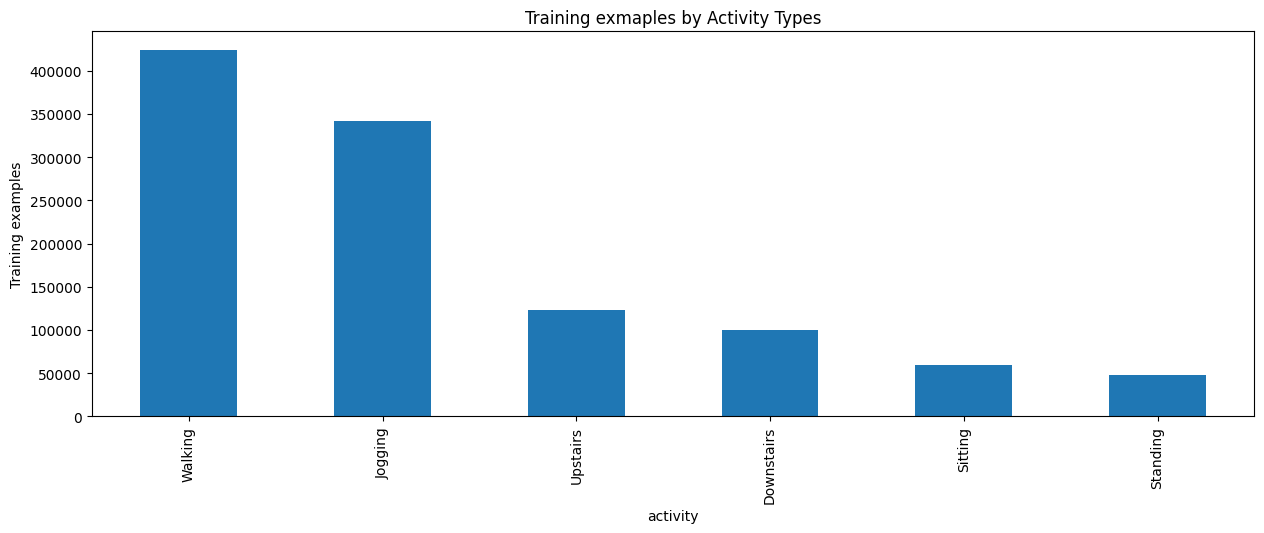

In [3]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar', title='Training exmaples by Activity Types')

plt.show()

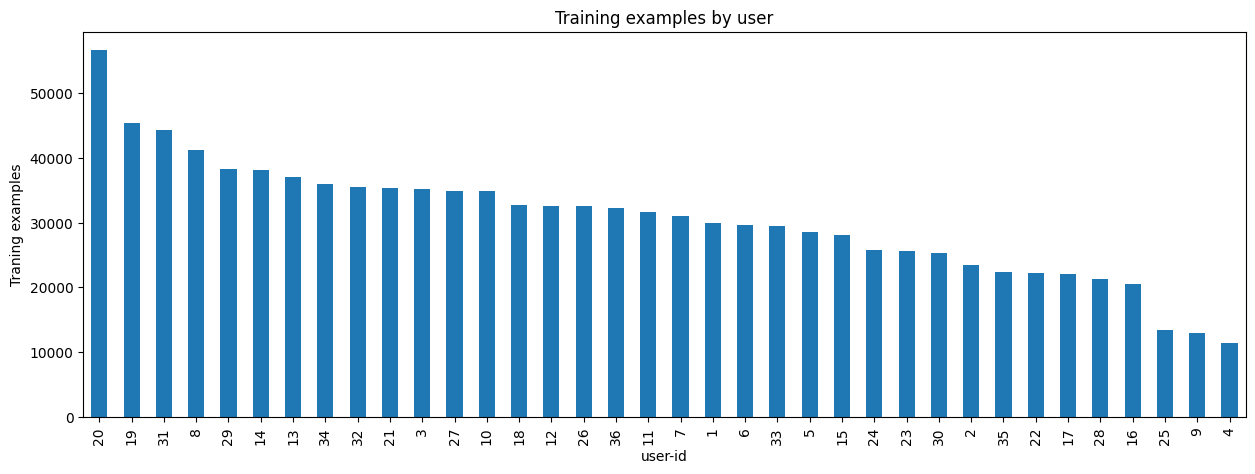

In [4]:
plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Traning examples')
df['user-id'].value_counts().plot(kind='bar', title='Training examples by user')

plt.show()

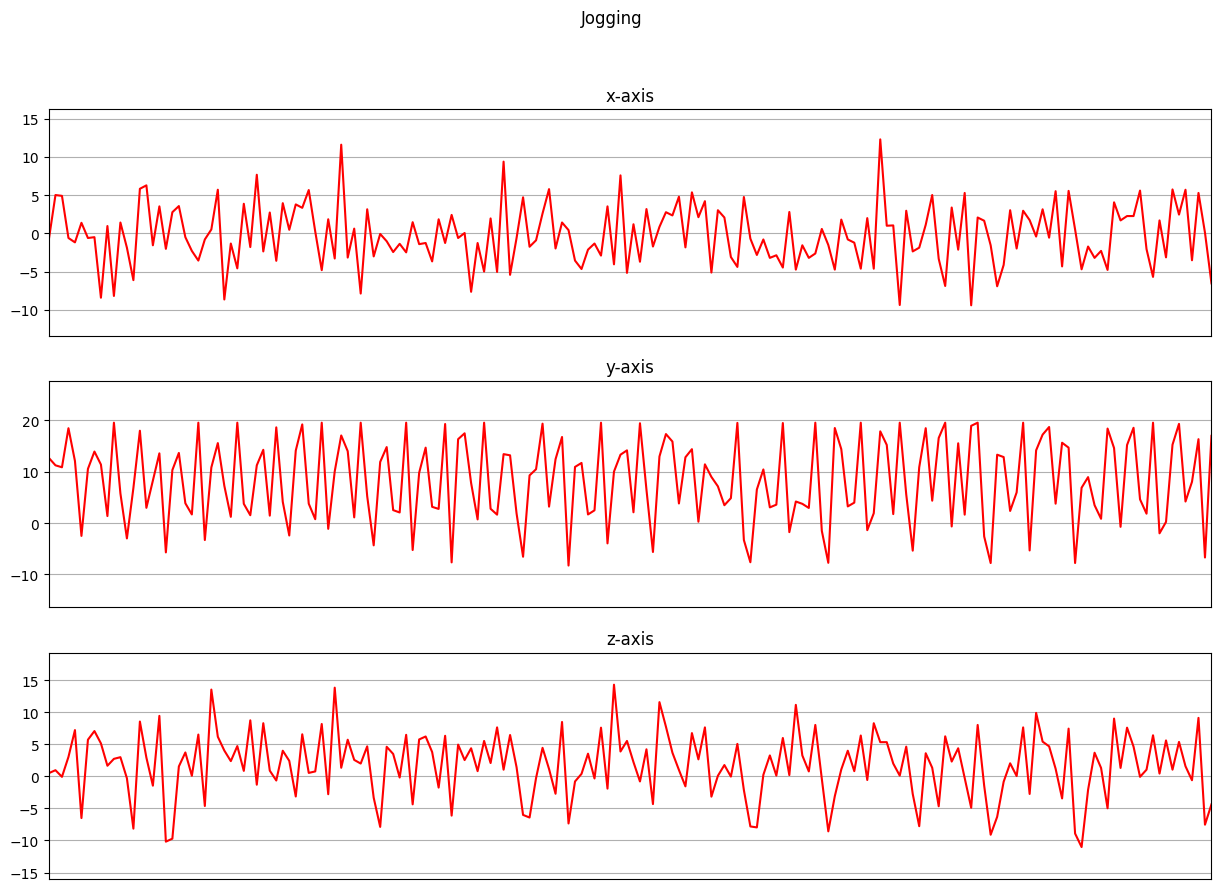

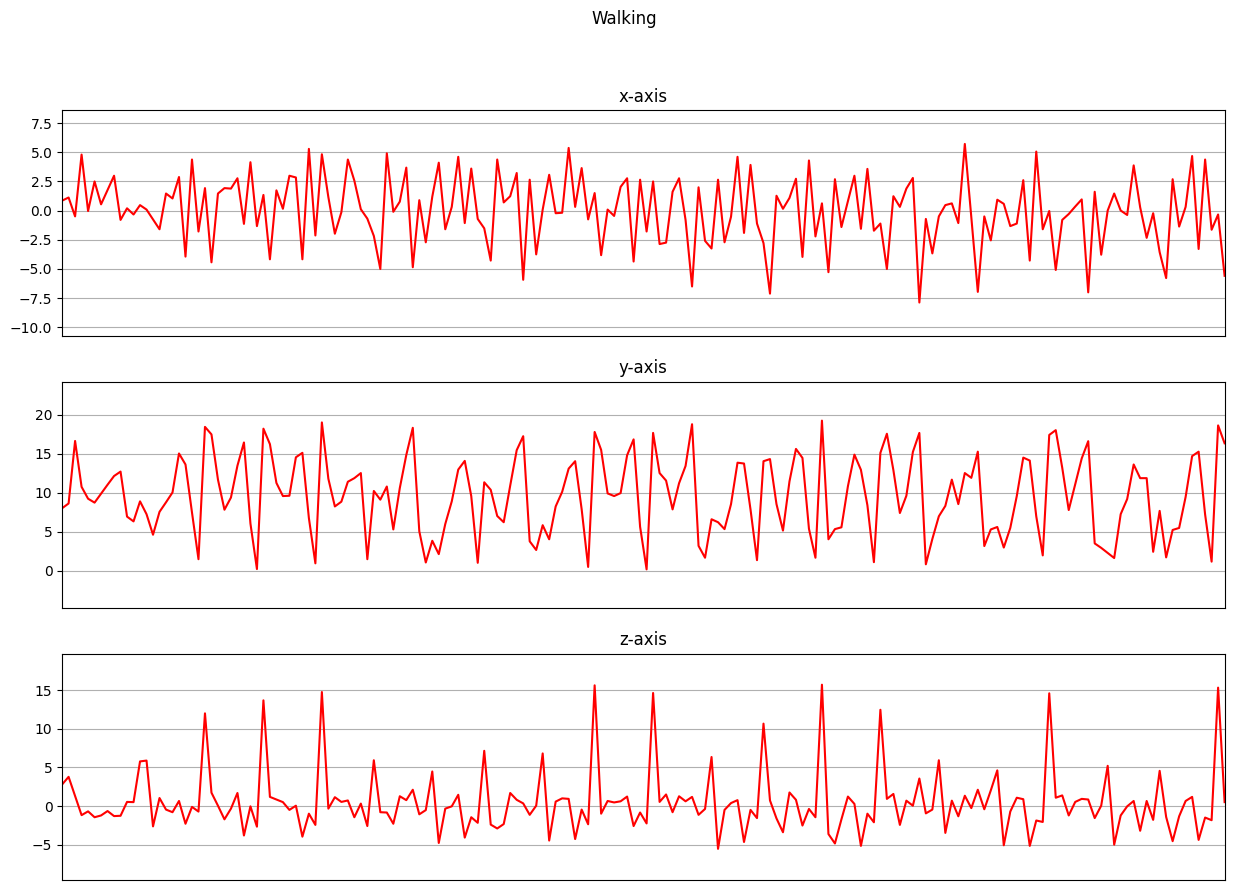

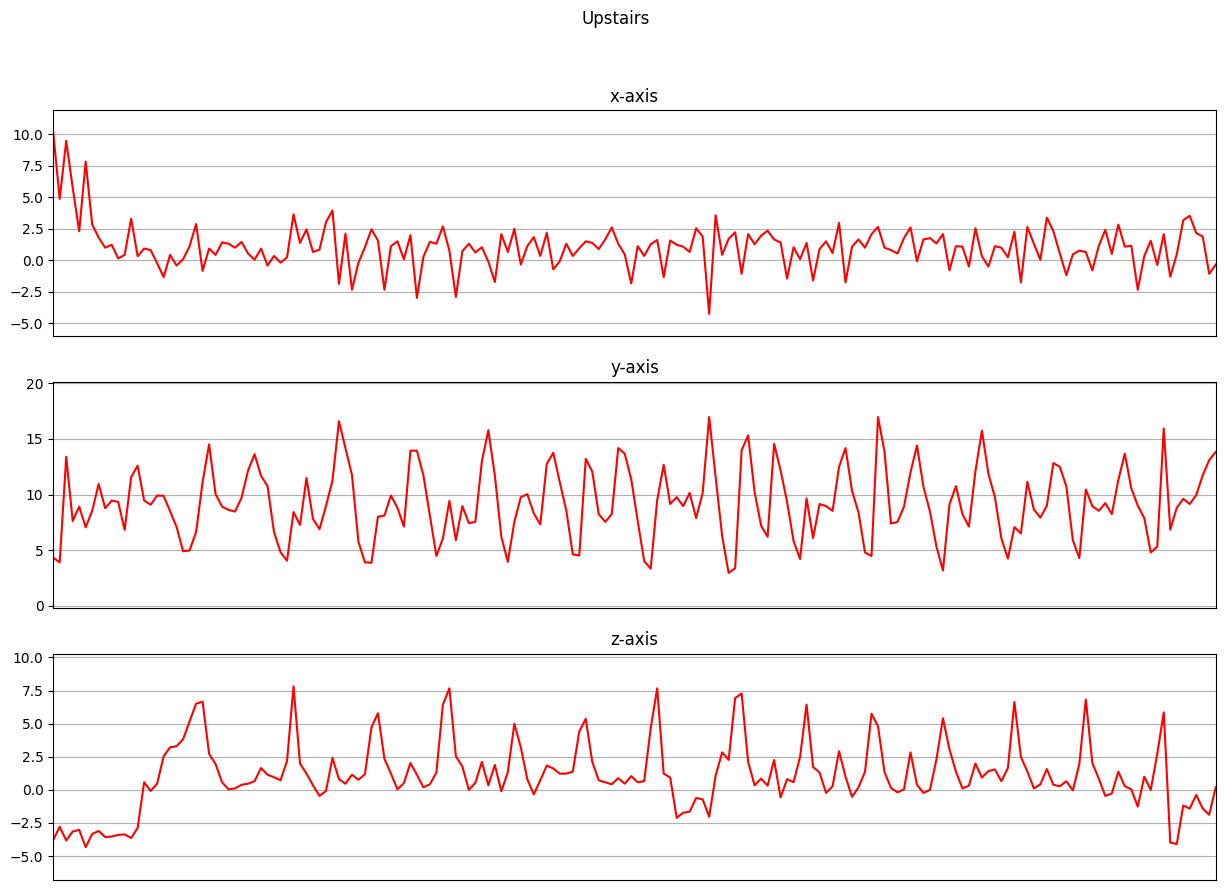

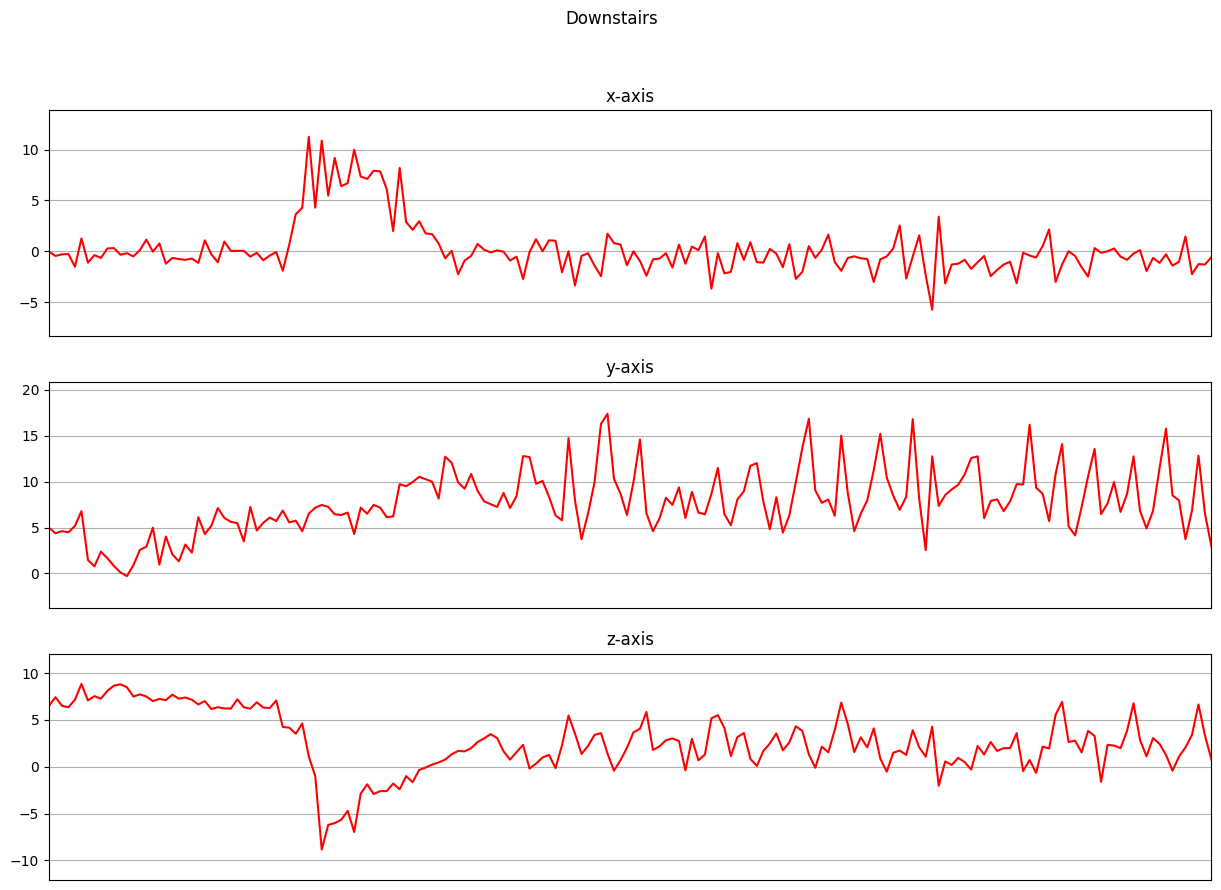

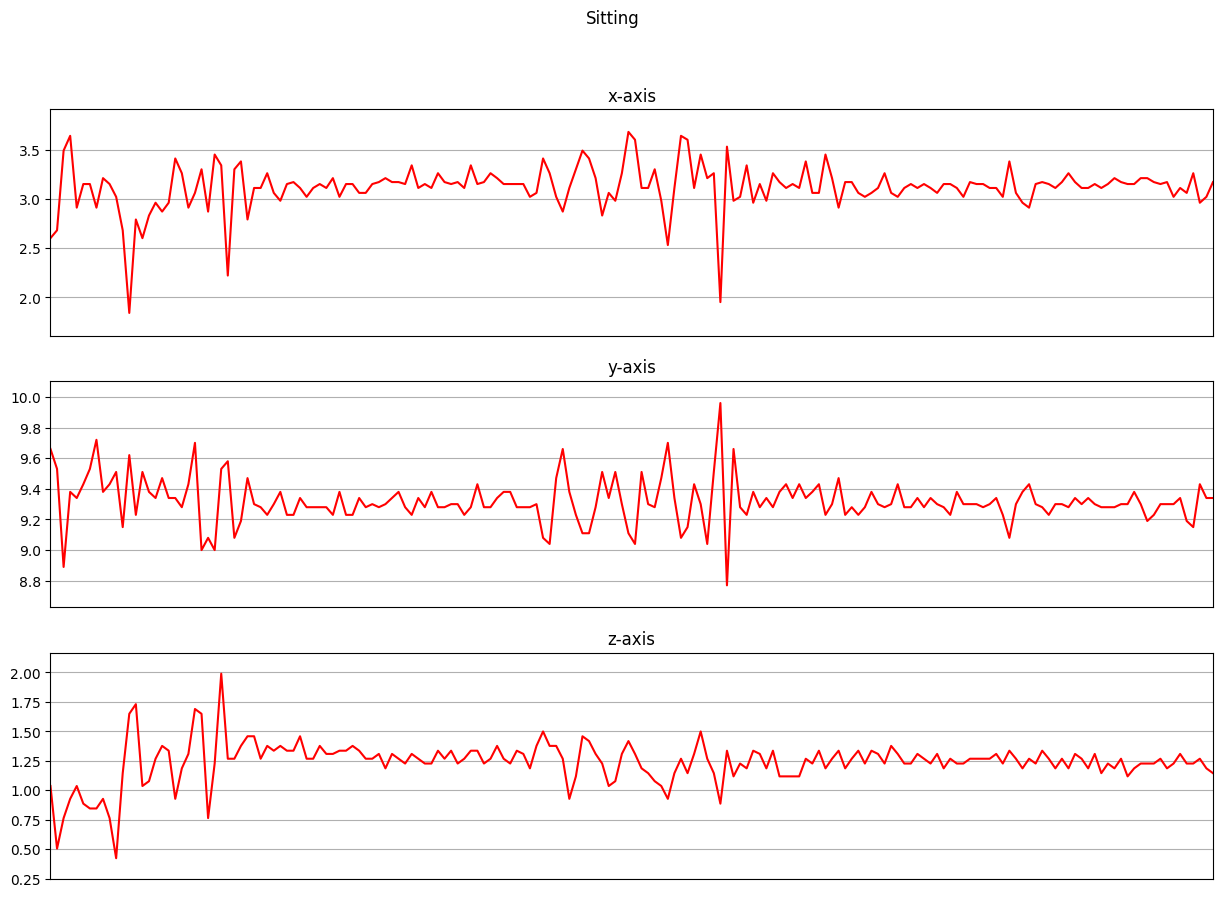

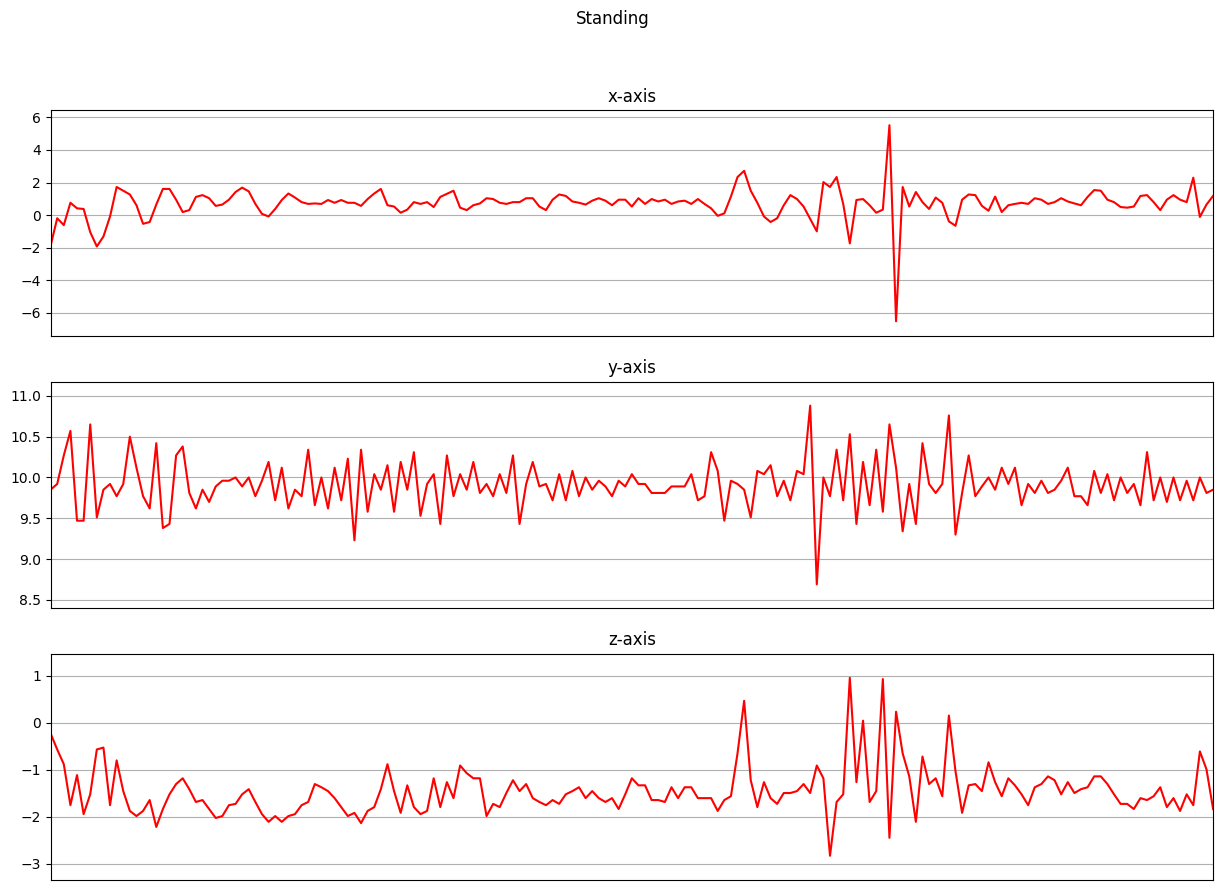

In [5]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r') # 빨간 색으로 그래프를 그림
    ax.set_title(title)
    ax.xaxis.set_visible(False) # x축 눈금 숨김
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)]) # 최소, 최댓값에 표준편차를 더해서 여유 공간을 줌
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180] # 조건에 맞는 행들 중 180개 선택
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10)) # subplot을 3행으로 배치, x를 공유
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2) # subplot 간의 간격을 띄움
    fig.suptitle(activity) # 전체 플롯의 제목 설정

In [6]:
# Label Encoding
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel()) # numpy로 변경, 1차원으로 평탄화 후 label encoding
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098194,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098195,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098196,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098197,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


Linear Interpolation (선형 보간법)
- 두 점 사이의 값을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법
- NaN값을 대체

In [7]:
# Linear Interpolation
interpolation_fn = interp1d(df['activityEncode'], df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()

for i in null_list:
  y = df['activityEncode'][i]
  value = interpolation_fn(y)
  df['Z'] = df['Z'].fillna(value)
  print(value)

4.75


In [8]:
# Data Split
# train: 1-27, test: 28-33
df['user-id'] = df["user-id"].astype(int)
df_test = df[df['user-id'] > 27].copy()
df_train = df[df['user-id'] <= 27].copy()

In [9]:
# Normalization (0-1)
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098194,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098195,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098196,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098197,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [10]:
# Segmentation
def segments(df, time_steps, step, label_name):
  N_FEATURES = 3 # feature의 개수 (x, y, z)
  segments = [] # x, y, z 값을 저장
  labels = [] # 구간별 대표 라벨을 저장
  for i in range(0, len(df) - time_steps, step):
    xs = df['X'].values[i:i+time_steps]
    ys = df['Y'].values[i:i+time_steps]
    zs = df['Z'].values[i:i+time_steps]

    label = mode(df[label_name][i:i+time_steps], keepdims=True).mode[0] # 라벨의 최빈값 계산
    segments.append([xs, ys, zs])
    labels.append(label)

  reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
  labels = np.asarray(labels)

  return reshaped_segments, labels

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [11]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [12]:
## Input and Output Dimensions
## 마지막 출력층의 출력 뉴런 수를 결정하는 데 필요
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size # fit()을 호출하면 .classes_ 속성에 라벨 목록이 정렬된 배열로 저장됨
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [13]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (20334, 240)


In [14]:
x_train =  x_train.astype('float32')
y_train =  y_train.astype('float32')

In [15]:
# One-Hot Encoding
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (20334, 6)


model.add(LSTM(32, return_sequences=True, input_shape=(input_shape, 1), activation='relu'))
- 32: 출력 벡터의 길이 (셀의 개수)
- return_sequences=True: 모든 시점의 출력 반환
- input_shape: time_steps 시점, 각 시점당 1개의 값
- 모델을 정의할 때는 배치 크기를 미리 정하지 않음

In [16]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape, 1), activation='relu'))
model.add(LSTM(32, return_sequences=True, activation='relu'))

# LSTM 출력: (batch_size, time_steps, 32) → 예: (None, input_shape, 32)
# Conv1D를 바로 사용 가능하므로 Reshape 생략 가능

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', strides=2))  # Input: (batch, time_steps, 32)
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 240, 32)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 240, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 120, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 29, 192)        │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,526 (170.02 KB)

 Trainable params: 43,142 (168.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train_hot, batch_size= 192, epochs=50)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.6000 - loss: 1.1406
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7875 - loss: 0.5654
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8093 - loss: 0.5101
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8245 - loss: 0.4654
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8400 - loss: 0.4319
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8460 - loss: 0.4076
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8520 - loss: 0.3853
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8616 - loss: 0.3591
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8747 - loss: 0.3299
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8827 - loss: 0.3199
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8837 - loss: 0.3099
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━

- history.history 안에 loss, accuracy 등 에포크 별 기록이 담겨 있음

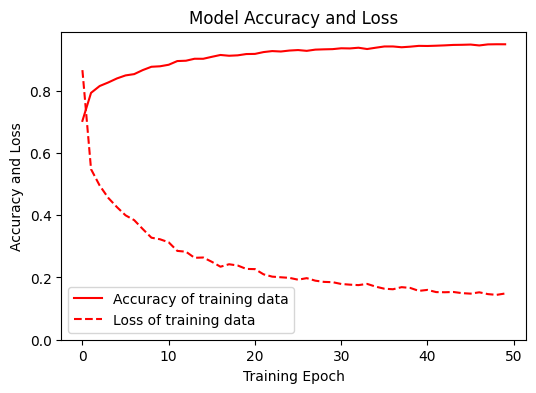

636/636 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.09      0.16      1792
         1.0       0.92      0.98      0.95      6567
         2.0       0.00      0.00      0.00      1048
         3.0       0.71      0.93      0.81       803
         4.0       0.00      0.00      0.00      2266
         5.0       0.65      1.00      0.79      7858

    accuracy                           0.75     20334
   macro avg       0.52      0.50      0.45     20334
weighted avg       0.65      0.75      0.66     20334



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0) # y축의 최소값을 0으로 설정
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1) # softmax 결과에서 가장 확률이 높은 클래스의 인덱스를 구함
print(classification_report(y_train, max_y_pred_train))

In [19]:
# Test
# normalization and segmentation
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [20]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])
print(score)

223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6895 - loss: 2.2780
Accuracy: 0.6681652069091797
Loss: 2.2436656951904297
[2.2436656951904297, 0.6681652069091797]


223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


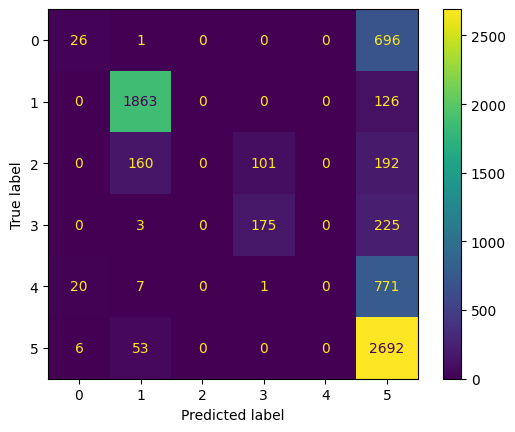

In [22]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1) # 가장 큰 값의 열 인덱스(클래스 번호) 반환
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm) # 히트맵 출력
cm_disp.plot()
plt.show()

In [23]:
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.50      0.04      0.07       723
           1       0.89      0.94      0.91      1989
           2       0.00      0.00      0.00       453
           3       0.63      0.43      0.51       403
           4       0.00      0.00      0.00       799
           5       0.57      0.98      0.72      2751

    accuracy                           0.67      7118
   macro avg       0.43      0.40      0.37      7118
weighted avg       0.56      0.67      0.57      7118



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
